In [1]:
%pwd  #look at the current work dir
%cd  /eris/u/jschubert/optimbias
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('meta_rl/src')
sys.path.append('rw_model/src')
from rw_fitting import predict_exp

/eris/u/jschubert/optimbias


# Generate DF

In [25]:
# first 500k model
base_path = f'/eris/scratch/jschubert/training/500k_first_model/'
path = base_path+f'rewards_not_set_rew_during_test_1/simulation/'

# latest 500k optimal model
base_path = '/eris/scratch/jschubert/training/500k_discount_entropy/RL__rc_0.8__efv_0.0__id_99'
path = base_path+'/simulation/'

csv_files = glob.glob(path + "/*.csv")
exp = (pd.read_csv(file) for file in csv_files)
exp = pd.concat(exp, ignore_index=True)
exp = exp.sort_values('test_part_idx')

set rewards to 0.5 if rewards was 1

In [26]:
exp['rewards'] = exp['rewards'].where(exp['rewards']==0, 0.5)

In [27]:
exp.head(10)

,test_part_idx,batch_idx,trials_idx,cues,actions,rewards,forgone_rewards,opt_actions,regrets,entropy,policy0,policy1,value_fn
1535,0,0,95,1.0,1.0,0.0,0.0,1.0,0.0,3.108893e-06,1.892812e-07,9.999998e-01,0.676145
1467,0,0,27,3.0,0.0,0.5,1.0,0.0,0.0,1.192093e-07,1.000000e+00,5.124337e-18,3.534589
1468,0,0,28,3.0,0.0,0.5,1.0,0.0,0.0,1.192093e-07,1.000000e+00,5.712992e-18,3.578199
1469,0,0,29,0.0,1.0,0.0,0.0,1.0,0.0,4.055080e-02,6.767177e-03,9.932328e-01,3.176031
1470,0,0,30,3.0,0.0,0.5,0.0,0.0,0.0,1.192093e-07,1.000000e+00,7.576837e-17,3.646505
1471,0,0,31,2.0,0.0,0.5,0.0,0.0,0.0,1.419531e-07,1.000000e+00,1.426628e-09,3.582515
1472,0,0,32,1.0,1.0,0.5,0.0,1.0,0.0,1.380166e-07,1.179704e-09,1.000000e+00,3.426359
1473,0,0,33,2.0,0.0,0.0,1.0,0.0,0.0,1.292203e-07,1.000000e+00,6.279476e-10,3.674509
1474,0,0,34,3.0,0.0,0.0,1.0,0.0,0.0,1.192093e-07,1.000000e+00,3.932371e-17,3.608840
1475,0,0,35,2.0,0.0,0.0,0.0,0.0,0.0,6.631136e-07,1.000000e+00,3.411687e-08,3.333555


In [29]:
orig = pd.read_csv('dat/lefebvre_exp/exp1.csv')
orig = orig.rename(columns={'participant_idx': "test_part_idx"})

dfs = [exp]

In [30]:
q_inital = np.asarray([[0.25,0.25],
                       [0.25,0.25],
                       [0.25,0.25],
                       [0.25,0.25]])

random_alpha_range = (0,1) # samples uniformly in between this range as an inital guess for alpha
random_beta_range = (0,5) # and for beta respectively.
optim_bounds = ([0,1],[0, np.inf]) #alpha, beta | bounds during optimization
n_optim_inits = 10 # how often the optimization procedure is repeated

In [31]:
res_part_list = []

for df in dfs:
    actions = df.pivot(index='test_part_idx',columns='trials_idx',values='actions').values.astype(int)
    rewards = df.pivot(index='test_part_idx',columns='trials_idx',values='rewards').values
    cues = df.pivot(index='test_part_idx',columns='trials_idx',values='cues').values.astype(int)

    pipeline = predict_exp(random_alpha_range, random_beta_range, q_inital, n_optim_inits, optim_bounds, concatenated_trial=False)
    res_part_list.append(pipeline.fit(actions,rewards,cues,bounded=True))


In [32]:
res_part_list[0].head()

,participant_idx,c_bic,pm_bic,c_nll,pm_nll,c_a,p_a,m_a,c_b,pm_b
0,0,57.440846,35.007907,24.156075,10.657431,0.209478,0.004261,0.000822,26.130453,4025.684959
1,1,87.500620,46.347834,39.185962,16.327395,0.322281,0.006483,0.001338,15.679223,1839.773827
2,2,60.408255,35.313879,25.639779,10.810417,0.498357,0.529493,0.051675,20.880331,29.975550
3,3,72.115392,56.440492,31.493348,21.373724,0.219375,0.389927,0.136281,26.724481,25.248783
4,4,106.323722,37.628031,48.597513,11.967493,0.343133,0.004519,0.001469,13.996308,1756.327590


In [34]:
df_orig = pd.read_csv('dat/ccn/rw_fitted_500k_rc1_efv0.csv')
df_orig = df_orig[df_orig['source'] == 'orig']
df_exp = res_part_list[0]
df_exp['source'] = 'rewards set to 0.5 while testing'
df_big = pd.concat([df_exp,df_orig], ignore_index=True)

df_big['bic_dif'] = df_big['c_bic'] - df_big['pm_bic']
df_big['is_pm'] = df_big['bic_dif'] >= 0
df_big['c_1/b'] = 1 / df_big['c_b']
df_big['pm_1/b'] = 1 / df_big['pm_b']

df_big = df_big.reset_index()
df_big.to_csv('rw_fitted_500k_latest_04_23_rew_during_test_0.5.csv', index=False, mode='x')

FileExistsError: [Errno 17] File exists: 'rw_fitted_500k_latest_04_23_rew_during_test_0.5.csv'

# Rewards of Test Run 1000 trials

I ran on a randomly initialized two armed bandit for 1000 trials.

In [ ]:
path = '/eris/scratch/jschubert/training/test_compare_with_rw/test_df.csv'
df1k = pd.read_csv(path)
df1k.head()

In [ ]:
df1k['test_part_idx'].unique().shape

In [ ]:
df1k.groupby(['test_part_idx']).sum()['rewards'].describe()

In [ ]:
df1k.groupby(['test_part_idx']).sum()['uo_rewards'].mean()

# Start with plotting

In [2]:
#df = pd.read_csv('dat/ccn/rw_fitted_500k_first_rew_during_test_1.csv')
df = pd.read_csv('rw_fitted_500k_latest_04_23_rew_during_test_0.5.csv')
df.head()




,index,participant_idx,c_bic,pm_bic,c_nll,pm_nll,c_a,p_a,m_a,c_b,pm_b,source,level_1,bic_dif,is_pm,c_1/b,pm_1/b
0,0,0,57.440846,35.007907,24.156075,10.657431,0.209478,0.004261,0.000822,26.130453,4025.684959,rewards set to 0.5 while testing,NaN,22.432939,True,0.038270,0.000248
1,1,1,87.500620,46.347834,39.185962,16.327395,0.322281,0.006483,0.001338,15.679223,1839.773827,rewards set to 0.5 while testing,NaN,41.152786,True,0.063779,0.000544
2,2,2,60.408255,35.313879,25.639779,10.810417,0.498357,0.529493,0.051675,20.880331,29.975550,rewards set to 0.5 while testing,NaN,25.094376,True,0.047892,0.033361
3,3,3,72.115392,56.440492,31.493348,21.373724,0.219375,0.389927,0.136281,26.724481,25.248783,rewards set to 0.5 while testing,NaN,15.674900,True,0.037419,0.039606
4,4,4,106.323722,37.628031,48.597513,11.967493,0.343133,0.004519,0.001469,13.996308,1756.327590,rewards set to 0.5 while testing,NaN,68.695690,True,0.071447,0.000569


In [4]:
df_mean = df.groupby('source').mean()[['c_bic','pm_bic', 'c_nll', 'pm_nll', 'c_a', 'p_a', 'm_a', 'c_1/b', 'pm_1/b']]
df_sem = df.groupby('source').sem()[['c_bic','pm_bic', 'c_nll', 'pm_nll', 'c_a', 'p_a', 'm_a', 'c_1/b', 'pm_1/b']]

df_measure = pd.concat([df_mean,df_sem], keys=['mean','sem'], names=['measure'])

In [5]:
df_measure = df_measure.reset_index()


In [8]:
df_measure.set_index(['source','measure']).sort_values('source').round(2)

c_bic  pm_bic  c_nll  pm_nll   c_a  \
source                           measure                                       
orig                             mean     99.55   93.67  45.21   39.99  0.31   
                                 sem       4.49    4.67   2.24    2.33  0.05   
rewards set to 0.5 while testing mean     60.54   36.39  25.71   11.35  0.34   
                                 sem       3.04    1.22   1.52    0.61  0.03   

                                           p_a   m_a  c_1/b  pm_1/b  
source                           measure                             
orig                             mean     0.33  0.17   0.15    0.10  
                                 sem      0.05  0.04   0.03    0.02  
rewards set to 0.5 while testing mean     0.43  0.11   0.04    0.01  
                                 sem      0.06  0.02   0.00    0.00

First t-test MetaRL PM vs C

In [6]:
from scipy.stats import ttest_ind

df_str = ['orig', 'simulations_rewards_set_to_1_while_testing']
orig_pm_bic = df[df['source']==df_str[0]][['pm_bic']]
orig_c_bic = df[df['source']==df_str[0]][['c_bic']]
metarl_pm_bic = df[df['source']==df_str[1]][['pm_bic']]
metarl_c_bic = df[df['source']==df_str[1]][['c_bic']]

In [ ]:
ttest_ind(metarl_pm_bic, metarl_c_bic,)

t-test MetaRL vs Humans

In [ ]:
ttest_ind(metarl_c_bic, orig_c_bic)

In [ ]:
ttest_ind(metarl_pm_bic, orig_pm_bic)

# Plots 

In [3]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [4]:
# Using seaborn's style
text_width = 505.89 #in path
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "sans-serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

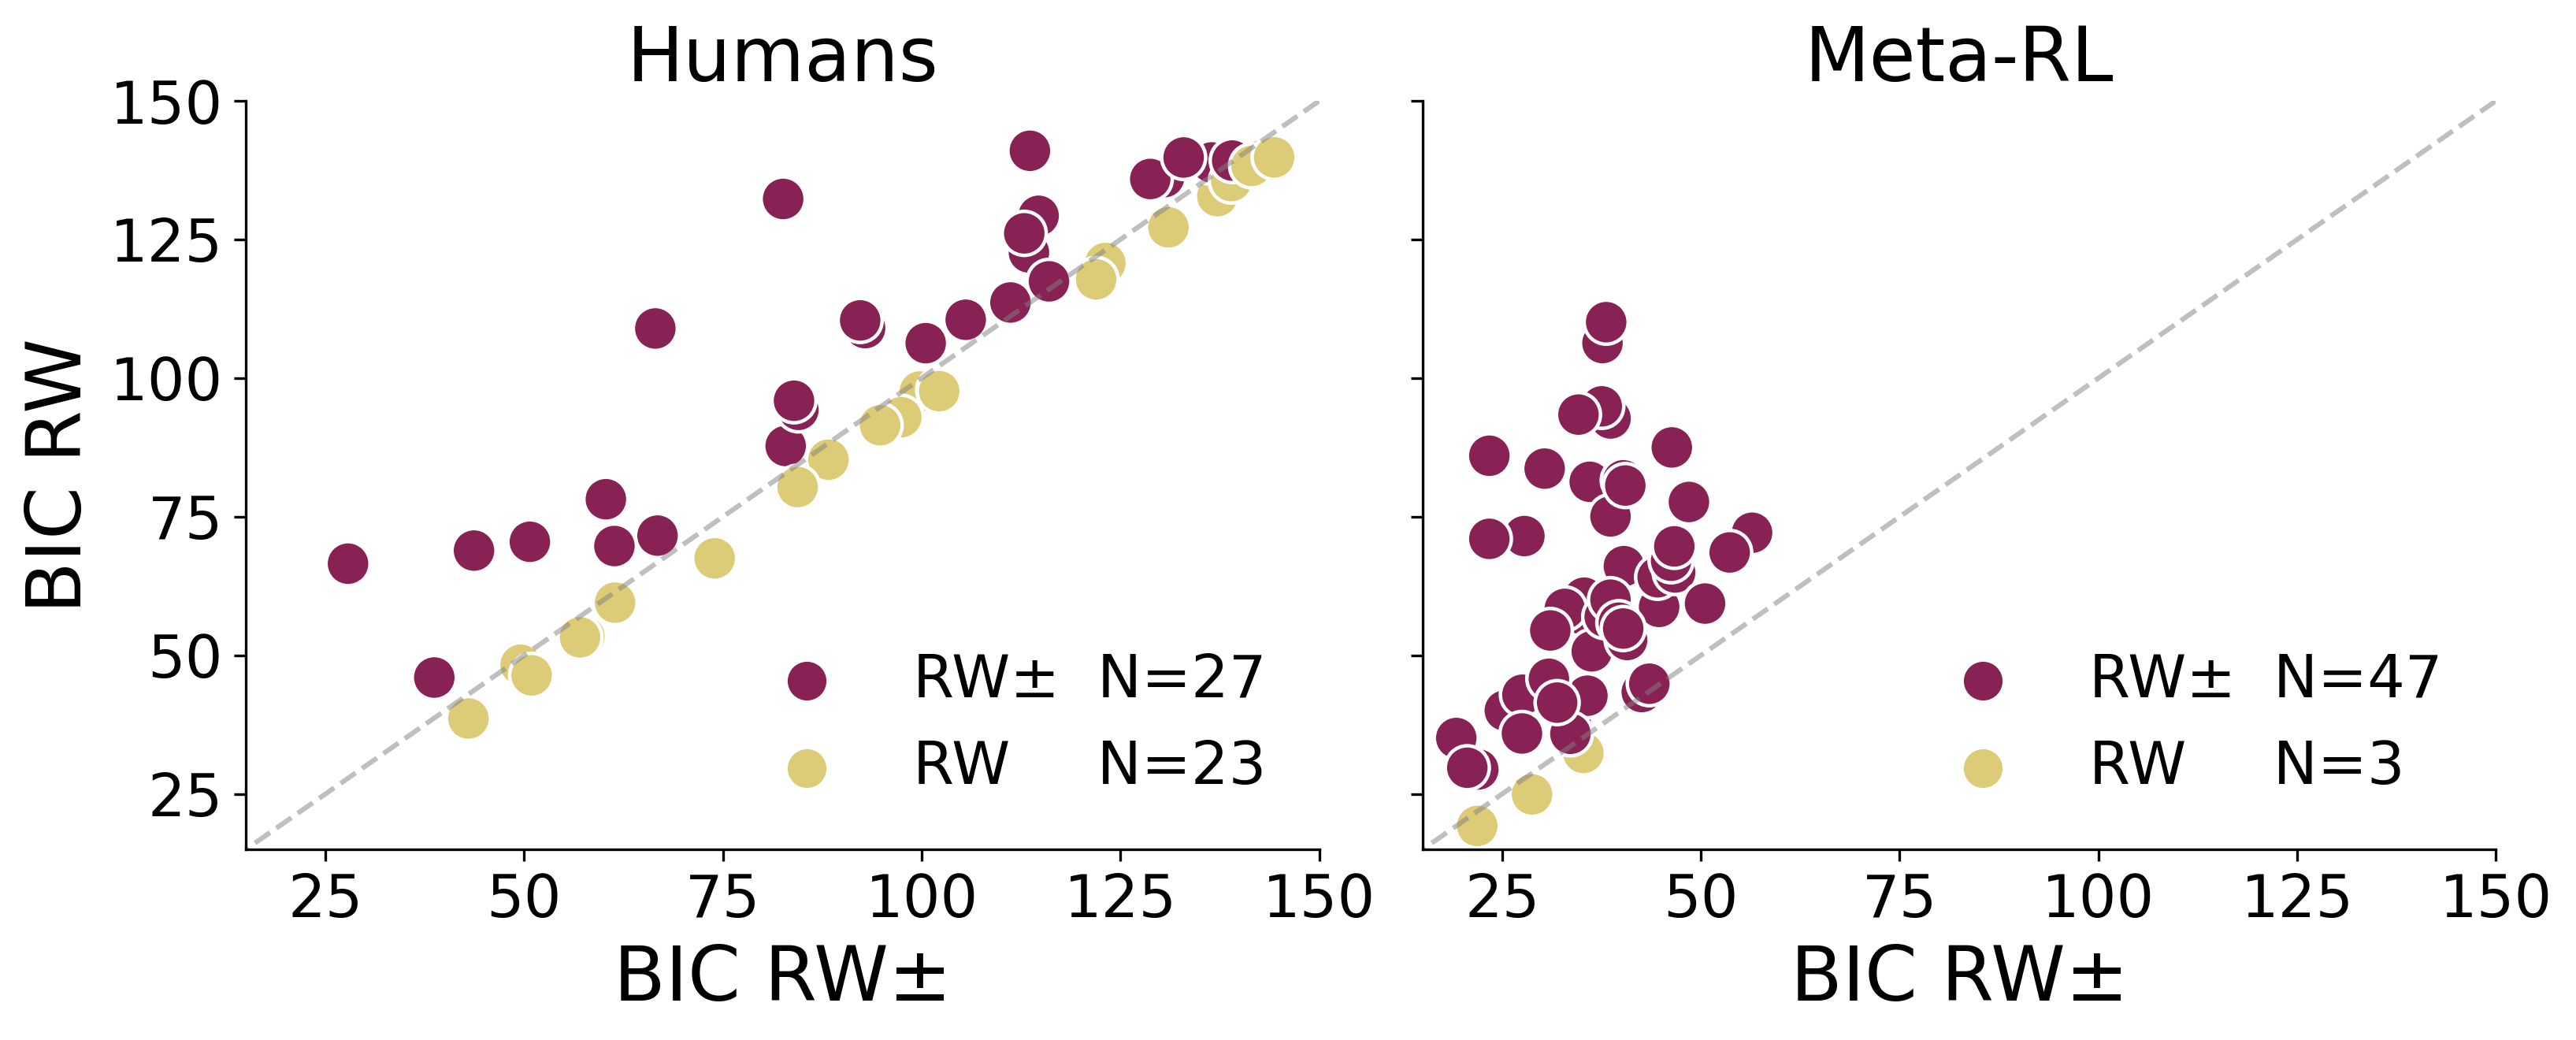

In [7]:
fig, axs = plt.subplots(1,2, dpi=300, figsize=(11,4.5), sharey=True)
axs = axs.flatten()
title= ['Humans', 'Meta-RL']
df_str = ['orig', 'rewards set to 0.5 while testing']


for i, str_df in enumerate(df_str):   
    ax = axs[i]
    plt_df = df[df.source == str_df]
    sns.scatterplot( x=plt_df[('pm_bic')], y=plt_df[('c_bic')], hue=plt_df['is_pm'], ax=ax, palette=['#DDCC77', '#882255'], s=180)
    sns.despine(ax=ax)
    ax.plot([0,150],[0,150],linestyle='dashed',color='grey',alpha=.5)
    ax.set_xlim((15,150))
    ax.set_ylim((15,150))
    ax.set_ylabel('BIC RW', fontsize=23)
    ax.set_xlabel('BIC RW±', fontsize=23)
    ax.tick_params(labelsize=18)
    rwpm = str(np.sum(plt_df.is_pm))
    nrwpm = str(np.sum(~plt_df.is_pm))

    ax.set_title(title[i], fontsize=23)

    # replace legend with text "Subjects" False = RW, True = RW±
    handles, labels = ax.get_legend_handles_labels()
    order=[1,0]
    handles = [handles[idx] for idx in order]
    ax.legend(handles= handles, labels=[f'RW± N='+rwpm, 'RW   N='+nrwpm], loc='lower right', frameon=False, fontsize=18, markerscale=1.8)

#plt.suptitle('Model comparison of RW and RW± in terms of BIC', fontsize=20)
plt.tight_layout()
plt.show()


fig.tight_layout()
fig.savefig('bic.pdf', format='pdf', bbox_inches='tight')

In [23]:
df[df.source == 'orig'].describe()

,index,participant_idx,c_bic,pm_bic,c_nll,pm_nll,c_a,p_a,m_a,c_b,pm_b,level_1,bic_dif,c_1/b,pm_1/b
count,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,74.50000,24.50000,99.554185,93.669671,45.212744,39.988313,0.314129,0.326942,0.171401,296.710897,499.112295,24.50000,5.884514,0.154836,0.100851
std,14.57738,14.57738,31.727090,32.989557,15.863545,16.494779,0.364689,0.350765,0.296317,715.362153,970.589094,14.57738,12.888008,0.237041,0.134011
min,50.00000,0.00000,38.618618,27.850214,14.744961,7.078585,0.000511,0.000000,0.000000,0.923869,1.255304,0.00000,-6.462780,0.000330,0.000265
25%,62.25000,12.25000,70.764667,62.703608,30.817985,24.505282,0.033656,0.017439,0.000652,5.227735,7.598352,12.25000,-3.733328,0.007657,0.006763
50%,74.50000,24.50000,102.090187,96.104138,46.480745,41.205547,0.139337,0.224103,0.027813,16.512437,12.689126,24.50000,1.927440,0.060591,0.078808
75%,86.75000,36.75000,128.750870,120.459007,59.811087,53.382981,0.509020,0.457910,0.114681,131.421616,171.076911,36.75000,9.626562,0.192653,0.131609
max,99.00000,49.00000,140.997725,144.330621,65.934514,65.318788,1.000000,1.000000,1.000000,3027.444926,3773.983721,49.00000,49.731601,1.082405,0.796620


In [20]:
df[df.source == 'rewards set to 0.5 while testing'].describe()

,index,participant_idx,c_bic,pm_bic,c_nll,pm_nll,c_a,p_a,m_a,c_b,pm_b,level_1,bic_dif,c_1/b,pm_1/b
count,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0.0,50.000000,50.000000,50.000000
mean,24.50000,24.50000,88.776884,85.030366,39.824094,35.668661,0.229699,0.149059,0.167000,440.967628,569.858322,NaN,3.746518,0.060264,0.033378
std,14.57738,14.57738,19.808875,16.181831,9.904437,8.090916,0.292586,0.207318,0.280948,902.696607,738.748272,NaN,10.896871,0.071096,0.040661
min,0.00000,0.00000,48.305733,50.249533,19.588518,18.278244,0.000497,0.000989,0.000000,3.119859,7.185743,NaN,-4.563877,0.000301,0.000366
25%,12.25000,12.25000,75.212474,72.932727,33.041889,29.619841,0.038710,0.002123,0.000503,13.195460,19.524216,NaN,-3.273969,0.013588,0.000845
50%,24.50000,24.50000,88.955989,84.148569,39.913647,35.227762,0.124266,0.049074,0.041272,26.863044,59.940349,NaN,0.191333,0.037434,0.016692
75%,36.75000,36.75000,100.034776,94.579094,45.453040,40.443025,0.245228,0.239095,0.171055,74.145561,1183.801047,NaN,7.089263,0.075969,0.051338
max,49.00000,49.00000,130.844417,124.482538,60.857860,55.394747,1.000000,1.000000,1.000000,3325.552745,2729.167866,NaN,43.768237,0.320527,0.139164


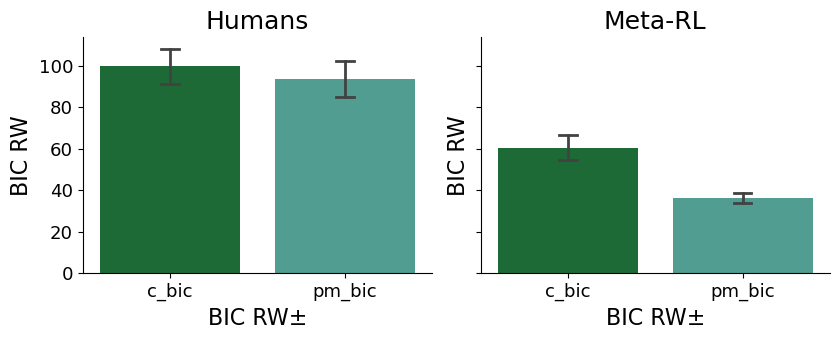

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8.5,3.5), sharey=True)
axs = axs.flatten()
title= ['Humans', 'Meta-RL']
df_str = ['orig', 'rewards set to 0.5 while testing']


for i, str_df in enumerate(df_str):   
    ax = axs[i]
    plt_df = df[df.source == str_df]

    scatter_pm = plt_df[[('c_bic'),('pm_bic')]]
    scatter_pm_melted = scatter_pm.melt()
    fig_args = {'x': 'variable',
                'y': 'value',
                'data': scatter_pm_melted,
                'capsize':0.1,
                'errwidth':2,
                'palette': ['#117733', '#44AA99']}

    sns.barplot(ax=ax, **fig_args)


    sns.despine(ax=ax)
    
    ax.set_ylabel('BIC RW', fontsize=16)
    ax.set_xlabel('BIC RW±', fontsize=16)
    ax.tick_params(labelsize=13)
    rwpm = str(np.sum(plt_df.is_pm))
    nrwpm = str(np.sum(~plt_df.is_pm))

    ax.set_title(title[i], fontsize=18)

#plt.suptitle('Model comparison of RW and RW± in terms of BIC', fontsize=20)
plt.tight_layout()
plt.show()


fig.tight_layout()
fig.savefig('bic.pdf', format='pdf', bbox_inches='tight')

In [ ]:
import numpy as np
import tikzplotlib as tpl
from matplotlib import pyplot as plt
from matplotlib import ticker

# and now we save it:
tpl.save(
    "example.tex",  # this is name of the file where your code will lie
    axis_width="\\figwidth",  # we want LaTeX to take care of the width
    axis_height="\\figheight",  # we want LaTeX to take care of the height
    # if the figure contains an image in the background (this one doesn't), this is where LaTeX (!) should search for the png.
    tex_relative_path_to_data="./",
    # we want the plot to look *exactly* like here (e.g. axis limits, axis ticks, etc.)
    strict=True,
)

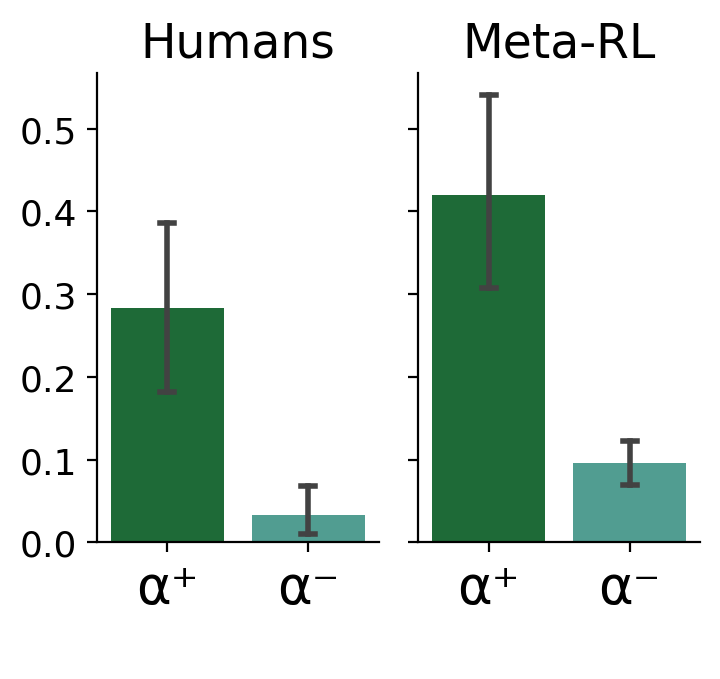

In [8]:
from statannotations.Annotator import Annotator

fig, axs = plt.subplots(1,2, figsize=(3.7,3.5), dpi=200, sharey=True)
axs = axs.flatten()

title= ['Humans', 'Meta-RL']
df_str = ['orig', 'rewards set to 0.5 while testing']

for i, str_df in enumerate(df_str):   
    ax = axs[i]
    plt_df = df[df.source == str_df]
    plt_df = plt_df[plt_df.is_pm == True]
    scatter_pm = plt_df[[('p_a'),('m_a')]]
    scatter_pm_melted = scatter_pm.melt()
    fig_args = {'x': 'variable',
                'y': 'value',
                'data': scatter_pm_melted,
                'capsize':0.1,
                'errwidth':2,
                'palette': ['#117733', '#44AA99']}
    pairs = [(('p_a', 'm_a'))]


    sns.barplot(ax=ax, **fig_args)
    sns.despine(ax=ax)
    ax.set_xticklabels(['α⁺','α⁻'], fontsize=19)
    ax.set_ylabel('')
    ax.set_xlabel(' ', fontsize=13)
    ax.tick_params(axis='y',labelsize=13)
    rwpm = np.sum(plt_df.is_pm)
    nrwpm = np.sum(~plt_df.is_pm)
    ax.set_title(title[i], fontsize=17)

    configuration = {'test': 't-test_ind',
                    'comparisons_correction':None,
                    'text_format':'star'}
    #annotator = Annotator(ax=ax, pairs=pairs, **fig_args, plot='barplot')
    #annotator.configure(**configuration).apply_test().annotate()
#plt.suptitle('Learning Rates of “RW± fits”',fontsize=20)
plt.tight_layout()
plt.show()
fig.tight_layout()
fig.savefig('lr.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=1,figsize=(12.2, 3.5),gridspec_kw={'width_ratios': [3,3,1,1]})


def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)
    return axs
    

set_share_axes(axs[0:1], axs[1], sharey=True)
#set_share_axes(axs[2:3], sharey=True)


#fig = plt.figure(figsize=(12.2,3.5))

#ax1 = fig.add_subplot(1, 8, (1,3))
#ax2 = fig.add_subplot(1, 8, (4,6), sharey = ax1)
#ax3 = fig.add_subplot(1, 8, 7)
#ax4 = fig.add_subplot(1, 8, 8)

#axs = [ax1, ax2, ax3, ax4]

title= ['Participants', 'RL$^2$ agent']
df_str = ['orig', 'simulations_rewards_set_to_1_while_testing']


for i, str_df in enumerate(df_str):   
    ax = axs[i]
    if i == 1: 
        ax.sharey(axs[0])
        plt.setp(ax.get_yticklabels(), visible=False)
    plt_df = df[df.source == str_df]
    sns.scatterplot( x=plt_df[('pm_bic')], y=plt_df[('c_bic')], hue=plt_df['is_pm'], ax=ax, palette=['#DDCC77', '#882255'], s=100)
    sns.despine(ax=ax)
    ax.plot([0,150],[0,150],linestyle='dashed',color='grey',alpha=.5)
    ax.set_xlim((15,150))
    ax.set_ylim((15,150))
    ax.set_ylabel('BIC RW', fontsize=16)
    ax.set_xlabel('BIC RW±', fontsize=16)
    ax.tick_params(labelsize=13)
    rwpm = str(np.sum(plt_df.is_pm))
    nrwpm = str(np.sum(~plt_df.is_pm))
    ax.set_title(title[i], fontsize=18)

    # replace legend with text "Subjects" False = RW, True = RW±
    handles, labels = ax.get_legend_handles_labels()
    order=[1,0]
    handles = [handles[idx] for idx in order]
    ax.legend(handles= handles, labels=[f'RW± N='+rwpm, 'RW   N='+nrwpm], loc='lower right', frameon=False, fontsize=13, markerscale=1.5)


for i, str_df in enumerate(df_str):   
    ax = axs[i+2]
    plt_df = df[df.source == str_df]
    plt_df = plt_df[plt_df.is_pm == True]
    scatter_pm = plt_df[[('p_a'),('m_a')]]
    scatter_pm_melted = scatter_pm.melt()
    fig_args = {'x': 'variable',
                'y': 'value',
                'data': scatter_pm_melted,
                'capsize':0.1,
                'errwidth':2,
                'palette': ['#117733', '#44AA99']}
    pairs = [(('p_a', 'm_a'))]


    sns.barplot(ax=ax, **fig_args)
    sns.despine(ax=ax)
    ax.set_xticklabels(['α⁺','α⁻'], fontsize=20)
    ax.set_ylabel('')
    ax.set_xlabel(' ', fontsize=13)
    ax.set_yticklabels([])
    rwpm = np.sum(plt_df.is_pm)
    nrwpm = np.sum(~plt_df.is_pm)
    ax.set_title(title[i], fontsize=18)

    #configuration = {'test': 't-test_ind',
    #                'comparisons_correction':None,
    #                'text_format':'simple'}
    #annotator = Annotator(ax=ax, pairs=pairs, **fig_args, plot='barplot')
    #annotator.configure(**configuration).apply_test().annotate()

plt.tight_layout()
plt.show()
fig.tight_layout()
fig.savefig('bic_lr.pdf', format='pdf', bbox_inches='tight')

# Old Plots


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=200)
axs = axs.flatten()

#title= ['Comparison α⁺ vs α⁻', 'Participant Data (Recovered)']
plt_df = df[df.source == 'simulations_rewards_set_to_1_while_testing']

ax = axs[0]
p1 = sns.scatterplot(x=plt_df[('m_a')], y=plt_df[('p_a')], hue=plt_df['is_pm'], palette=['grey','red'], ax=ax)
ax.plot([-0.1,1],[-0.1,1], c='grey', linewidth=1,linestyle='dashed')
ax.plot([0,0],[-0.1,1], c='grey', linewidth=1,linestyle='dashed')
ax.plot([-.1,1],[0,0], c='grey', linewidth=1,linestyle='dashed')
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_ylabel('α⁺')
ax.set_xlabel('α⁻')
rwpm = np.sum(plt_df.is_pm)
nrw = np.sum(~plt_df.is_pm)
#ax.set_title(title[0])
# replace legend with text "Subjects" False = RW, True = RW±
handles, labels = ax.get_legend_handles_labels()
order=[1,0]
handles = [handles[idx] for idx in order]
ax.legend(handles= handles, labels=['RW±', 'RW'], title='Model Runs', loc='lower right')

ax = axs[1]
scatter_pm = plt_df[[('p_a'),('m_a')]]
scatter_pm_melted = scatter_pm.melt()
fig_args = {'x': 'variable',
            'y': 'value',
            'data': scatter_pm_melted,
            'palette': ('orange',),
            'capsize':0.1,
            'errwidth':2}
pairs = [(('p_a', 'm_a'))]
configuration = {'test': 't-test_ind',
                'comparisons_correction':None,
                'text_format':'star'}
sns.barplot(ax=ax, **fig_args)
ax.set_xticklabels(['α⁺','α⁻'])
ax.set_ylabel('Arbitrary units')
ax.set_xlabel('')
rwpm = np.sum(plt_df.is_pm)
nrw = np.sum(~plt_df.is_pm)
#ax.set_title(title[1])
annotator = Annotator(ax=ax, pairs=pairs, **fig_args, plot='barplot')
annotator.configure(**configuration).apply_test().annotate()

plt.suptitle('Comparison α⁺ vs α⁻', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:

from statannotations.Annotator import Annotator

fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=200)
axs = axs.flatten()

title= ['Meta-RL Agent', 'Participant Data (Recovered)']


for i, str_df in enumerate(df.source.unique()): 
    
    ax = axs[i]
    
    plt_df = df[df.source == str_df]


    scatter_pm = plt_df[[('p_a'),('m_a')]]
    scatter_pm_melted = scatter_pm.melt()

    fig_args = {'x': 'variable',
                'y': 'value',
                'data': scatter_pm_melted,
                'palette': ('orange',),
                'capsize':0.1,
                'errwidth':2}

    pairs = [(('p_a', 'm_a'))]

    configuration = {'test': 't-test_ind',
                    'comparisons_correction':None,
                    'text_format':'star'}

    sns.barplot(ax=ax, **fig_args)
    ax.set_xticklabels(['α⁺','α⁻'])
    ax.set_ylabel('Arbitrary units')
    ax.set_xlabel('')
    rw = np.sum(plt_df.is_pm)
    nrwpm = np.sum(~plt_df.is_pm)
    ax.set_title(title[i])
    annotator = Annotator(ax=ax, pairs=pairs, **fig_args, plot='barplot')
    annotator.configure(**configuration).apply_test().annotate()
plt.show()